***JUSTIN BUTLER***

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

***Part i)***

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
%matplotlib inline

machInitials = [2,4]

gamma = 1.4
beta = 45
rampAngle = 5 #degrees
dummy = 1
t = 0
DRC = np.pi/180
RDC = 180/np.pi
obliqueValues = []

def obliqueShockCheck(s,M):
    OSC_temp = [np.tan(rampAngle * DRC) * np.tan(s * DRC),
                (((gamma+1)*M**2)/(2*(M**2*(np.sin(s * DRC))**2-1)))-1
               ]
    upstreamOfShockRatio = OSC_temp[0] * OSC_temp[1]
    del(OSC_temp)
    return(upstreamOfShockRatio)

def obliqueShockMach(s,M):
    obliqueMach = []
    #print('s: ' + str(s))
    for j in range(len(M)):
        #print("s: " + str(s[j][0]))
        OSM_temp = [ (np.sin((s[j][0]-rampAngle) * DRC))**2,
                    (gamma - 1)*M[j]**2*(np.sin(s[j][0] * DRC))**2 + 2,
                    2*gamma*M[j]**2*(np.sin(s[j][0] * DRC))**2 - (gamma-1)
                    ]
        obliqueMach.append(np.sqrt((OSM_temp[1]/OSM_temp[2])/OSM_temp[0]))
    del(OSM_temp)
    return(obliqueMach)

def obliqueShock(beta,M):
    #Ensure M input is a list
    try:
        M[0]
    except:
        M = [M]
    #
    dummy = 1
    t = 0
    # For/While loop
    for i in range(len(M)):
        while dummy > t:
            t = obliqueShockCheck(beta,M[i])
            beta -= 0.001
            if beta < 0: break
        obliqueValues.append([beta])
        #reset the values
        beta = 45
        t = 0
        if len(obliqueValues) == len(M):
            valTemp = obliqueShockMach(obliqueValues,M)
            [obliqueValues[x].append(valTemp[x]) for x in range(len(M))]
            del(valTemp)
    return(obliqueValues)
def prandtlMeyer(M):
    PM_temp = [np.sqrt((gamma+1)/(gamma-1)),
               np.arctan(np.sqrt(((gamma-1)/(gamma+1))*(M**2 -1))),
               np.arctan(np.sqrt(M**2 -1))]
    prMach = PM_temp[0] * PM_temp[1] - PM_temp[2]
    del(PM_temp)
    return(prMach)

#-----------------------------------#
######          MAIN          #######    
#-----------------------------------#

afterShock = obliqueShock(45, machInitials)
beta4 = afterShock[1][0]
M4 = afterShock[1][1]
#print("[beta,mach] for M=2 then M=4 \n" + str(afterShock))
turnAngle = prandtlMeyer(afterShock[0][1])
print("Total flow turning:\n" + str(turnAngle * RDC) + " degrees")

#Change angles to radians for remainder of code:
beta4 = beta4 * DRC
rampAngle = rampAngle * DRC

Total flow turning:
21.342732939749716 degrees


***Part ii)***

In [176]:
## RAMP INITIAL VALUES ##
#Oblique Shock values (on design)
m4ObShockLength = 1/(np.sin(beta4))
muOb = (np.arcsin(1/M4))
nuOb = prandtlMeyer(M4)


#Cowl Coordinates
cowlLip = [np.sqrt(m4ObShockLength**2 - 1),1]

#Random Angles
other = np.pi - muOb
eta = np.pi - other - (beta4 - rampAngle)

#Wedge Coordinates
rampLength = (m4ObShockLength / np.sin(other)) * np.sin(eta)
rampDim = [(rampLength * np.cos(rampAngle)), (rampLength * np.sin(rampAngle))]
wedToCowl = np.sqrt(np.sum([(cowlLip[i] - rampDim[i])**2 for i in range(0,2)]))
rampHat = wedToCowl * np.sin(muOb)
rampH = 1 - rampDim[1]

In [177]:
def actualTurning():
    vM4 = nuOb
    #print("vM4: " + str(vM4))
    vM2 = turnAngle
    delV = vM4 - vM2
    #print(delV)
    mIter = 1.8
    vIter = vM2
    while vIter < delV:
        vIter = prandtlMeyer(mIter)
        mIter += 0.000001
    return([mIter, vIter])

def xyCoordFunction(M):
    temp = [M4/M,
           2 + (gamma-1)*M**2,
           2 + (gamma-1)*M4**2,
           (gamma+1)/(2*(gamma-1))]
    hHat = rampHat * temp[0] * (temp[1]/temp[2])**temp[3]
    mu = np.arcsin(1/M)
    nu = prandtlMeyer(M)
    theta = rampAngle + nuOb - nu
    h = (hHat*np.sin(theta+mu))/(np.cos((np.pi/2)-mu))
    delX = (h/np.tan(mu+theta+nuOb-nu))
    x = cowlLip[0] - (h/np.tan(mu+theta+nuOb-nu))
    y = 1 - h
    xy = [x,y]
    return(xy)
            
   

In [178]:
#-----------------------------------#
######          MAIN          #######    
#-----------------------------------#


## Calculating Actual Turning at Mach 4 ##
actTurn = actualTurning()[0]
print("Ending Mach Number: " + str(actTurn))

Ending Mach Number: 2.50926200005473


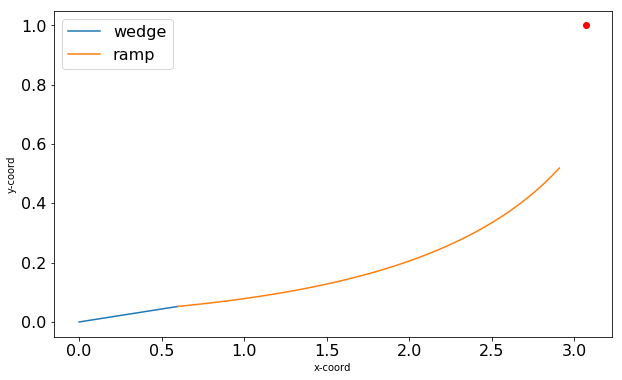

The apparant change in slope between the orange and blue lines has been
looked at extensively and looks to be only the result of the odd scaling of the image.


In [186]:
#Lin-space for the mach numbers
mLinRev = np.linspace(actTurn,afterShock[1][1], 100)
#Correct Order
mLin = [mLinRev[len(mLinRev) - (j+1)] for j in range(len(mLinRev))]

#print("mLin" + str(mLin))
#generate x and y coordinates
xyCoord = []
i = 0
for item in mLin:
    xyCoord.append(xyCoordFunction(item))



#GRAPHING TIME
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot([0,rampDim[0]], [0,rampDim[1]], '-', label="wedge")
plt.plot([item[0] for item in xyCoord], [jtem[1] for jtem in xyCoord], '-', label='ramp')
plt.plot(cowlLip[0],cowlLip[1],'ro')

#plt.title('Mach number to altitude', fontsize=16)

#plt.ylim(0,1.5)
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()

print("The apparant change in slope between the orange and blue lines has been")
print("looked at extensively and looks to be only the result of the odd scaling of the image.")


***Part iii)***

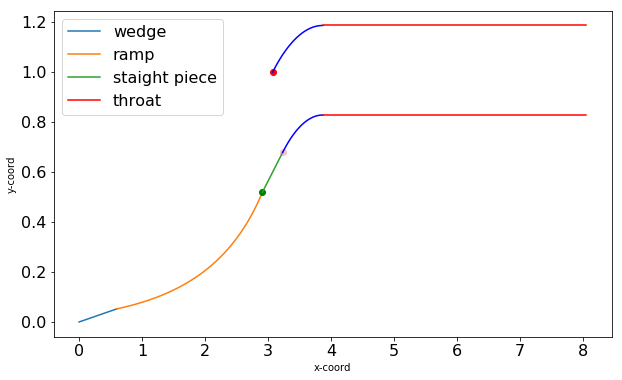

In [187]:
'''
The closest point dictates the duct height, as the rest of the distances will be of equal length going up
the duct. So we need a radius, R = 4 * duct height, and then we draw a circle and adjust it so the arc
only goes up to the horizontal.
'''
#Solving for the parameters of our circle, using the coordinates given
phi = rampAngle + nuOb - prandtlMeyer(mLin[-1])
lastCoord = [xyCoord[-1][0],xyCoord[-1][1]]

def distance(p1, p2):
    d = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return(d)

def findingDuct():
    x = []
    y = []
    d = []
    x.append(lastCoord[0])
    y.append(lastCoord[1])
    d.append(distance(lastCoord,cowlLip))
    x.append(x[0]+0.001)
    y.append(y[0]+0.001*np.tan(phi))
    d.append(distance([x[1],y[1]],cowlLip))
    i = 1
    while d[i] < d[i-1]:
        x.append(x[i]+0.0001)
        y.append(y[i]+0.0001*np.tan(phi))
        d.append(distance([x[i+1],y[i+1]],cowlLip))
        i += 1
        if i > 1000000:
            break
    return([x[-2],y[-2],d[-2]])

normDuct = findingDuct()

## Creating the Circle ##
circCent = [normDuct[0] + 4*normDuct[2]*np.sin(phi),
         normDuct[1] - 4*normDuct[2]*np.cos(phi)]
arcAng = np.linspace((np.pi/2 + phi) - 2*np.pi, (-1*3*np.pi)/2, 100)
circX = (4*normDuct[2])*np.cos(arcAng) + circCent[0]
circY = (4*normDuct[2])*np.sin(arcAng) + circCent[1]
outCircX = (5*normDuct[2])*np.cos(arcAng) + circCent[0]
outCircY = (5*normDuct[2])*np.sin(arcAng) + circCent[1]

## Throat section ##
throatLength = normDuct[2] * 10 * ((machInitials[1]-1)/2.2)**0.5
endThroatInner = [circX[-1] + throatLength,
                circY[-1]]
endThroatOuter = [outCircX[-1] + throatLength,
                 outCircY[-1]]

#GRAPHING TIME

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot([0,xyCoord[0][0]], [0,xyCoord[0][1]], '-', label="wedge")
plt.plot([item[0] for item in xyCoord], [jtem[1] for jtem in xyCoord], '-', label='ramp')
plt.plot(xyCoord[-1][0],xyCoord[-1][1],'ro', color = 'green')
plt.plot(cowlLip[0],cowlLip[1],'ro')
plt.plot(normDuct[0],normDuct[1],'ro', color = 'pink')
plt.plot([xyCoord[-1][0],normDuct[0]],[xyCoord[-1][1],normDuct[1]],'-', label="staight piece")
plt.plot(circX,circY,'-',color='blue')
plt.plot(outCircX,outCircY,'-',color='blue')
plt.plot([circX[-1],endThroatInner[0]],[circY[-1],endThroatInner[1]],'-', color='red', label="throat" )
plt.plot([outCircX[-1],endThroatOuter[0]],[outCircY[-1],endThroatOuter[1]],'-', color='red' )

#plt.title('Mach number to altitude', fontsize=16)

#plt.xlim(.5,1)
#plt.ylim(0,.5)
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()